## Q2 - What’s the relationship between length of stay and survival rate?

In [50]:
# Imports for DFs & connecting to Postgres
import pandas as pd
import psycopg2

### Pull in Admissions data

In [51]:
# Connect to Postgres & get all records for ADMISSIONS
try:
    con = psycopg2.connect("host='localhost' dbname='mimic' user='postgres' password='postgres'")
    cur = con.cursor()
    cur.execute ("""SELECT * FROM mimiciii.admissions;""")
    con.commit()
    print('OK')
except Exception as e:
    print(e)  

OK


In [52]:
# Store ADMISSIONS result in var
admissions_all = cur.fetchall()

In [53]:
# Convert ADMISSIONS result to DF
admissions_df = pd.DataFrame(admissions_all, columns = ['row_id','subject_id', 'hadm_id', 'admittime', 'dischtime', 'deathtime',
 'admission_type', 'admission_location', 'discharge_location',
 'insurance', 'language', 'religion', 'marital_status', 'ethnicity',
 'edregtime', 'edouttime', 'diagnosis', 'hospital_expire_flag',
 'has_chartevents_data'])

In [54]:
# Create shortened DF of relevant cols; 'hospital_expire_flag' represents whether patient died at hospital during given admission
admission_short = admissions_df[['subject_id', 'hadm_id', 'admission_type', 'hospital_expire_flag']]

### Pull in ICUSTAY data

In [55]:
# Connect to Postgres & get all records for ICUSTAYS
try:
    con = psycopg2.connect("host='localhost' dbname='mimic' user='postgres' password='postgres'")
    cur = con.cursor()
    cur.execute ("""SELECT * FROM mimiciii.icustays;""")
    con.commit()
    print('OK')
except Exception as e:
    print(e)  

OK


In [56]:
# Store ICUSTAYS result in var
icustays_all = cur.fetchall()

In [57]:
# Convert ICUSTAYS result to DF
icustays_df = pd.DataFrame(icustays_all, columns = ['row_id', 'subject_id', 'hadm_id', 'icustay_id', 'dbsource', 'first_careunit', 'last_careunit', 'first_wardid', 'last_wardid', 'intime', 'outtime', 'los'])

In [58]:
# Create shortened DF of relevant cols; 'los' represents fractional days e.g. 2.0922 = 2 days, 2 hours, 12 minutes, & 46 seconds
icu_short = icustays_df[['subject_id', 'hadm_id', 'icustay_id', 'los']]

In [59]:
# Create merged DF, left join of admission_short to icu_short
icu_adm_short = icu_short.merge(admission_short, how='left', on='hadm_id', suffixes=('_icu', '_adm'))

In [60]:
# Group DF by admission, sum the length of stay in ICU, and capture whether patient died in hospital during the admission
icu_adm_los = icu_adm_short.groupby('hadm_id').agg({'los':'sum','hospital_expire_flag':'max'})

In [61]:
# Imports for generating plot
import seaborn as sns
from scipy import stats

C:\Users\bcrom\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


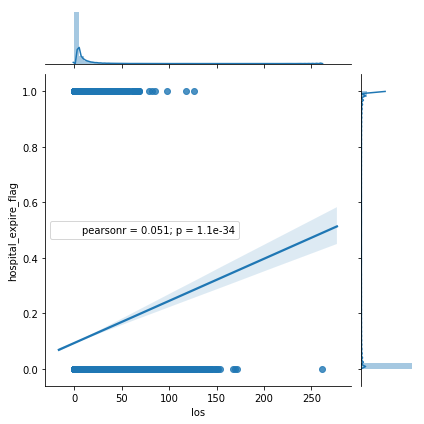

In [62]:
# Generate plot showing linear regression of 'hospital_expire_flag' given 'los' & the underlying distribution
h = sns.JointGrid(data=icu_adm_los, x='los', y='hospital_expire_flag')
h = h.plot(sns.regplot, sns.distplot)
h = h.annotate(stats.pearsonr)